**TITANIC SURVIVAL PREDICTION**

This segment initializes the Titanic survival prediction project by importing essential libraries for data manipulation, visualization, and machine learning. The Titanic dataset is loaded into a DataFrame, providing an initial overview of the data structure and content.

In [ ]:
#TITANIC SURVIVAL PREDICTION

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Loading the data set
df = pd.read_csv('Titanic-Dataset.csv')
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


**SEGMENT 2: Data Preprocessing**

Data preprocessing begins with handling missing values in the 'Age' and 'Embarked' columns, followed by the creation of new features like 'FamilySize' and 'Title' derived from existing columns. Unnecessary columns are dropped, and categorical variables are encoded using one-hot encoding for further analysis.

In [ ]:
#Data Preprocessing
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

df['FamilySize'] = df['SibSp'] + df['Parch']
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Dona'], 'Royalty')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace(['Mme'], 'Mrs')

df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)


**SEGMENT 3: Split the data into training and testing sets**

The dataset is split into training and testing sets to facilitate model training and evaluation. Features (X) and the target variable (y) are separated, and the data is divided into an 80-20 ratio for training and testing, respectively, ensuring adequate data for model validation.

In [ ]:
#Split the data into training and testing sets
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


**SEGMENT 4: Feature Scaling**

Feature scaling is performed on the training and testing sets using standardization to ensure all features have the same scale. This step is crucial for preventing certain features from dominating others during model training and improving the convergence of optimization algorithm

In [ ]:
#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**SEGMENT 5: Feature Selection**

Feature selection is conducted using the SelectKBest method with the ANOVA F-value as the scoring function. The top 10 features contributing the most to predicting the target variable are selected, optimizing model performance and reducing computational complexity.

In [ ]:
#Feature Selection
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)


**SEGMENT 6: Initialize and train the models with hyperparameter tuning**

Two classifier models, Random Forest and Gradient Boosting, are initialized and trained with hyperparameter tuning using grid search and cross-validation. The best hyperparameters are determined to optimize model performance, ensuring robustness and accuracy in survival predictions.

In [ ]:
#Initialize and train the models with hyperparameter tuning
random_forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_search_rf.fit(X_train_selected, y_train)
best_rf_model = grid_search_rf.best_estimator_

grid_search_gb = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid_gb, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_search_gb.fit(X_train_selected, y_train)
best_gb_model = grid_search_gb.best_estimator_


**SEGMENT 7: Voting Classifier Ensemble**

A Voting Classifier ensemble is created to combine the predictions of the best Random Forest and Gradient Boosting models. Soft voting is employed to aggregate class probabilities, leveraging the strengths of individual models for improved predictive performance.

In [ ]:
#Voting Classifier Ensemble
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', best_rf_model),
    ('gradient_boosting', best_gb_model)
], voting='soft')

voting_classifier.fit(X_train_selected, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(min_samples_split=10,
                                                     random_state=42)),
                             ('gradient_boosting',
                              GradientBoostingClassifier(learning_rate=0.2,
                                                         random_state=42))],
                 voting='soft')

**SEGMENT 8: Cross-validation**

Cross-validation is performed on the Voting Classifier ensemble to estimate its performance and generalization ability. Stratified K-Fold cross-validation ensures balanced class distributions across folds, providing reliable estimates of the model's accuracy and consistency.



In [ ]:
#Cross-validation
# Importing necessary libraries
from sklearn.ensemble import VotingClassifier

# Define the voting classifier ensemble
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', best_rf_model),
    ('gradient_boosting', best_gb_model)
], voting='soft')

# Fit the voting classifier to the training data
voting_classifier.fit(X_train_selected, y_train)

# Now you can use the voting classifier for further operations
cv_scores = cross_val_score(voting_classifier, X_train_selected, y_train, cv=StratifiedKFold(n_splits=5))


**SEGMENT 9: Make predictions**

Predictions are made on the test set using the trained Voting Classifier ensemble. The model's predictive ability is assessed by generating survival predictions for unseen data, enabling evaluation of its effectiveness in classifying passengers' survival outcomes.

In [ ]:
#Make predictions
y_pred = voting_classifier.predict(X_test_selected)

**SEGMENT 10: Evaluate the model**

The performance of the Voting Classifier ensemble is evaluated using metrics such as accuracy, classification report, and confusion matrix. These metrics provide insights into the model's predictive accuracy, precision, recall, and ability to correctly classify survival outcomes.

In [ ]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8156424581005587
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.68      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179

Confusion Matrix:
 [[99 11]
 [22 47]]


**SEGMENT 11: Feature Importances**

Feature importances from the best Random Forest model are computed to identify the most influential features in predicting survival outcomes. This analysis helps prioritize features for further investigation and model refinement.

In [ ]:
## Feature Importances (from the best Random Forest model)
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns

**SEGMENT 12: Correlation Matrix Heatmap**

A correlation matrix heatmap is generated to visualize the relationships between different features in the dataset. This visualization aids in identifying correlated features and understanding their impact on survival predictions.

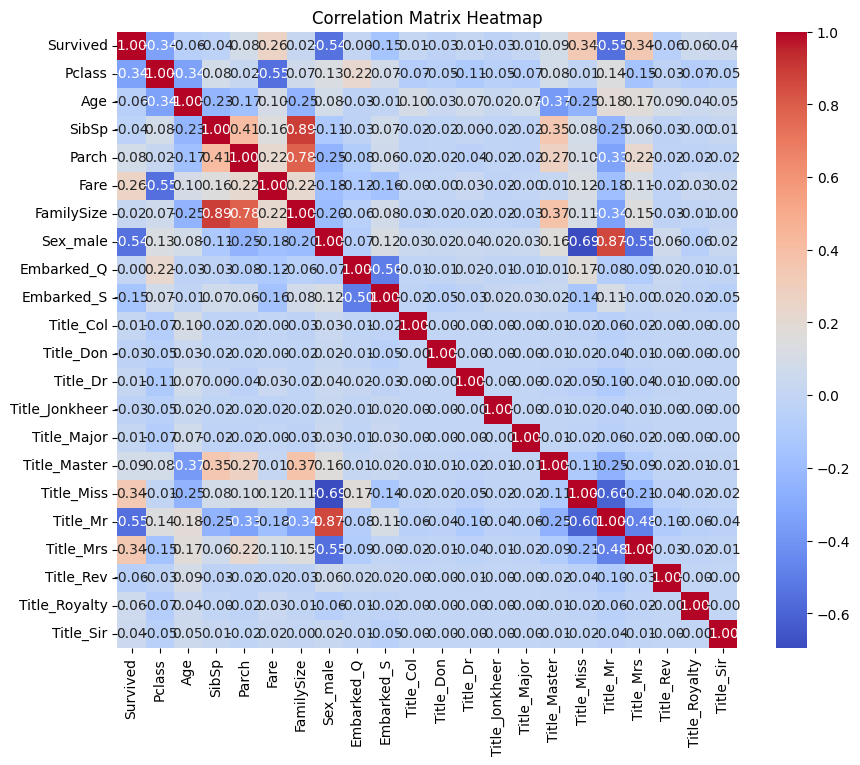

In [ ]:
#Correlation Matrix Heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

**SEGMENT 13: Age Distribution by Survival**

A histogram is plotted to visualize the distribution of passenger ages categorized by survival outcome. This visualization provides insights into the age distribution among survivors and non-survivors, highlighting potential factors influencing survival.

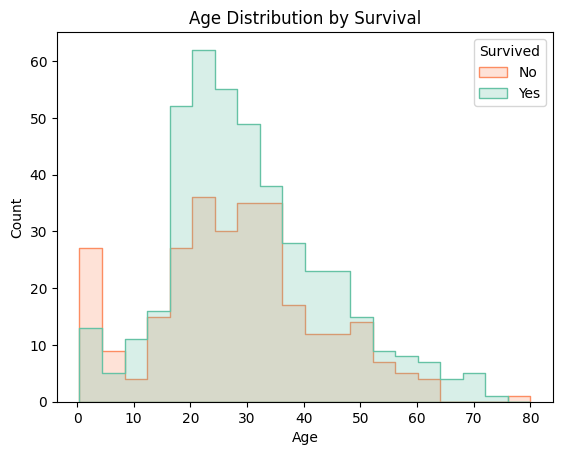

In [ ]:
#Age Distribution by Survival

import pandas as pd
import seaborn as sns

df = pd.read_csv('Titanic-Dataset.csv')

df['Age'] = pd.to_numeric(df['Age'])

sns.histplot(data=df, x='Age', hue='Survived', element='step', common_norm=False, palette='Set2')
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()


**SEGMENT 14: Fare Distribution by Class and Survival**

A boxplot is created to illustrate the distribution of fares across different passenger classes and survival outcomes. This visualization enables comparison of fare distributions among survivors and non-survivors, shedding light on socio-economic factors affecting survival.

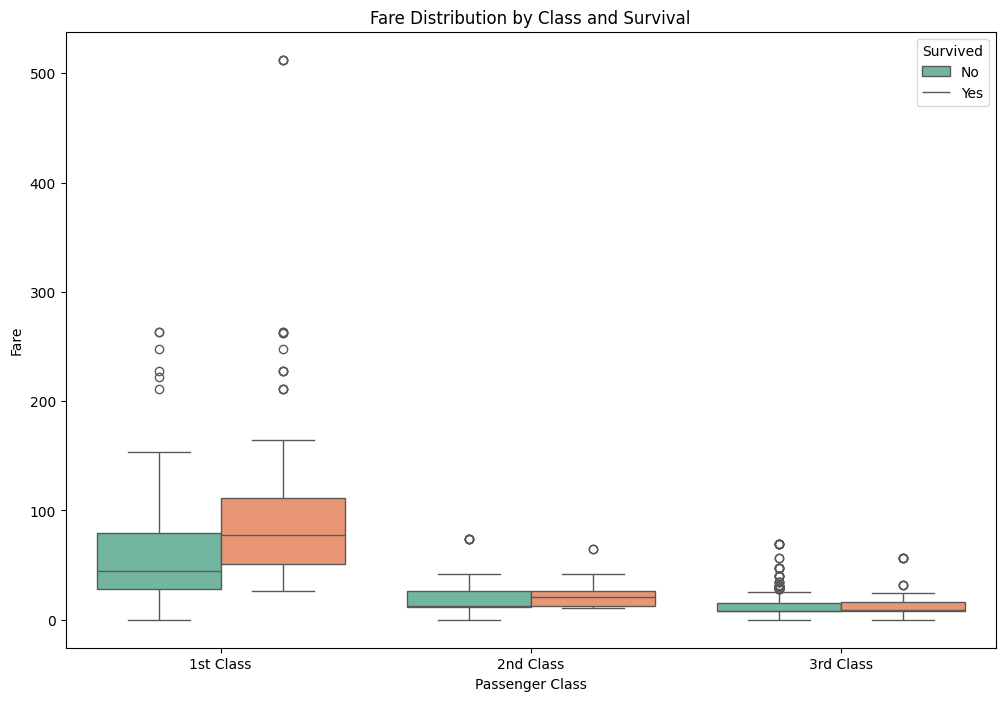

In [ ]:
#Fare Distribution by Class and Survival
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Titanic-Dataset.csv')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=df, palette='Set2')
plt.title('Fare Distribution by Class and Survival')
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.xticks([0, 1, 2], ['1st Class', '2nd Class', '3rd Class'])
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

**SEGMENT 15: Pair Plot of Features**

A pair plot is generated to visualize pairwise relationships between different features in the dataset. This visualization facilitates exploration of feature relationships, revealing potential patterns or trends that may influence survival predictions.

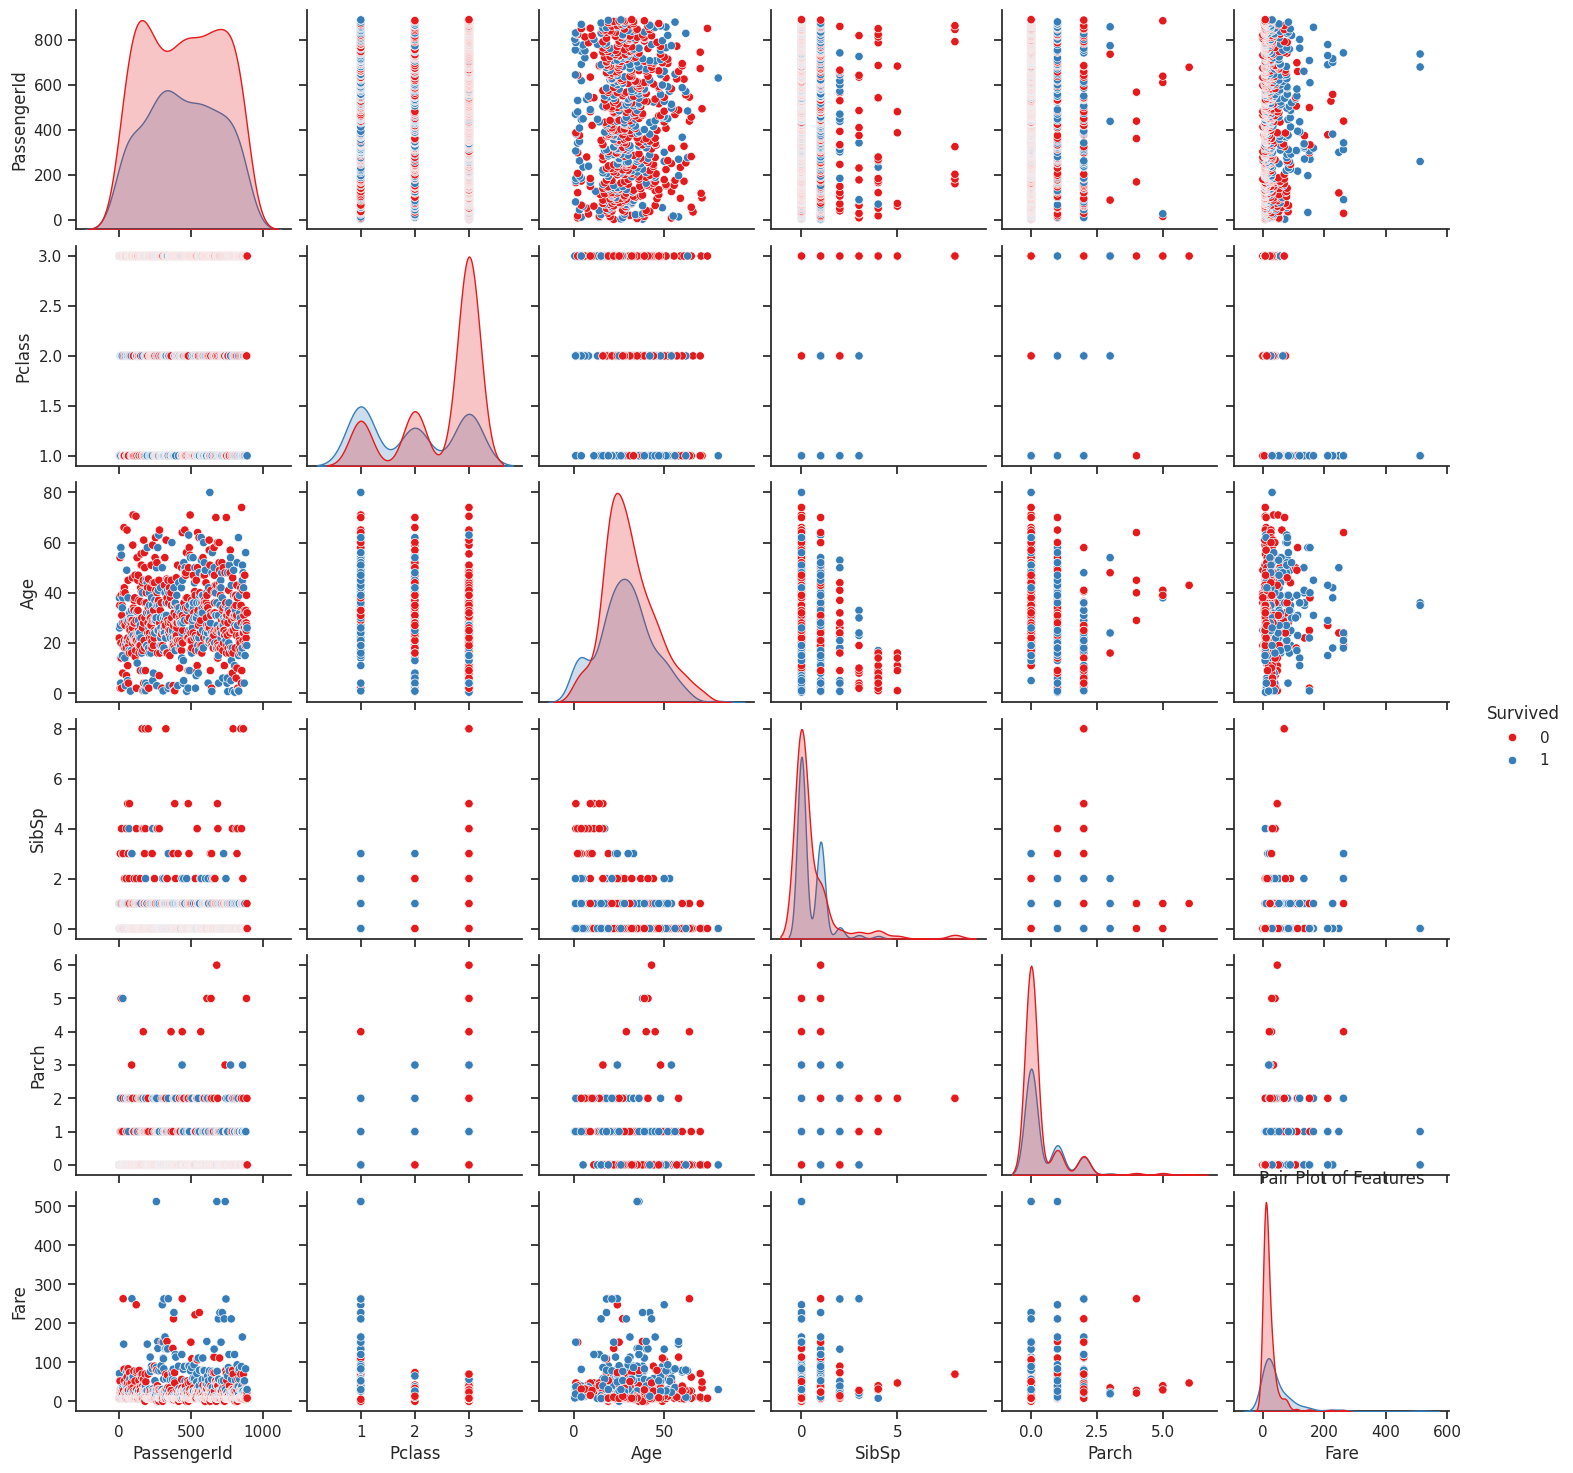

In [ ]:
#Pair Plot of Features

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Titanic-Dataset.csv')

sns.set(style="ticks")
sns.pairplot(data=df, hue='Survived', palette='Set1')
plt.title('Pair Plot of Features')
plt.show()